# Walking to the park on your computer - adventures in geospatial network analysis
## Shrividya Ravi
### https://github.com/shriv/maptime-jul21

# A proposed definition of walkability
>The extent to which the built environment is friendly to the presence of people living, shopping, visiting, enjoying or spending time in an area. 

[wikipedia](https://en.wikipedia.org/wiki/Walkability#cite_note-5) 

## A simple metric of local walkability
- Local walkability as the distance / travel time to a local amenity that is of value and should be accessible to all residents of the locality. 
- Use playgrounds as a municipal amenity that is designed to be a local public space. New Zealand councils prioritise the placement of these playgrounds with a small catchment that they consider 'local'. For Wellington, this is 600m.

<p style="text-align:center;"><img src="assets/wcc-playground-catchment.png" class="center" width="300"></p>


# Walking on a computer
Now that we have a basic metric walkability, how do we collect this data? Surveys would be great but they're expensive! Instead, let's do the walking on our computer.. 

## Datasets

There are 2 key datasets used in this analysis:
- *WCC playground locations*
    - Downloaded as zip file
    - [WCC open data portal](https://data-wcc.opendata.arcgis.com/datasets/wcc-playgrounds/explore)
    - In the github repo
 
- *Wellington street network*
    - Using Openstreetmap via Overpass API
    - Using Openstreetmap via `osmnx`


## Walking to the park analysis
A simplistic model that aggregates walking trips from any point in the city to the closest playground or, generalise to any other Point of Interest (POI). 

<p style="text-align:center;"><img src="./assets/accessibility-analysis-schematic.png" class="center" width="300"></p>


In [75]:
# Import some packages
import warnings
import os
from importlib import reload
import matplotlib.pyplot as plt

# simple html visualiser for slides export
from IPython.display import IFrame
import base64
def visualise_for_slides(folium_map):
    folium_map.fit_bounds(folium_map.get_bounds())
    html_str = folium_map.get_root().render()
    html_str = "data:text/html;base64," + base64.b64encode(html_str.encode('utf-8')).decode('utf-8')
    display(IFrame(src=html_str, width=900, height=600))
    
# Some configs
warnings.filterwarnings('ignore')
#pd.set_option('display.max_columns', 200)
%matplotlib inline

# Getting data for analysis

## Playground locations from WCC

In [76]:
import geopandas 
import pandas as pd

In [77]:
wcc_playgrounds = geopandas.read_file('zip://./data/WCC_Playgrounds.zip')
wcc_playgrounds.iloc[32:35]

,OBJECTID,location,suburb,playground,Housing,geometry
32,33,Kipling Street,Johnsonville,Kipling Street Play Area,No,POINT (174.79808 -41.22495)
33,34,Fraser Avenue,Johnsonville,Gilbert Young Play Area,No,POINT (174.80352 -41.22934)
34,35,Kanpur Road/Rajkot Terrace,Broadmeadows,Kanpur Road Play Area,No,POINT (174.79564 -41.23611)


In [78]:
wcc_playgrounds['lon'] = wcc_playgrounds['geometry'].apply(lambda p: p.x)
wcc_playgrounds['lat'] = wcc_playgrounds['geometry'].apply(lambda p: p.y)
wcc_playgrounds.iloc[32:35]

,OBJECTID,location,suburb,playground,Housing,geometry,lon,lat
32,33,Kipling Street,Johnsonville,Kipling Street Play Area,No,POINT (174.79808 -41.22495),174.798078,-41.224946
33,34,Fraser Avenue,Johnsonville,Gilbert Young Play Area,No,POINT (174.80352 -41.22934),174.803516,-41.229338
34,35,Kanpur Road/Rajkot Terrace,Broadmeadows,Kanpur Road Play Area,No,POINT (174.79564 -41.23611),174.795639,-41.236107


### Visualise a playground location (interactively)

In [79]:
import folium

In [114]:
map_playground = folium.Map(location=[wcc_playgrounds.iloc[32]['lat'], 
                                      wcc_playgrounds.iloc[32]['lon']],
                            fit_bounds=True,
                            zoom_start = 14)

folium.Marker(location = [wcc_playgrounds.iloc[32]['lat'], 
                          wcc_playgrounds.iloc[32]['lon']], 
              popup = wcc_playgrounds.iloc[32]['playground']).add_to(map_playground)

In [115]:
map_playground

### Visualise all playgrounds (interactively)

In [82]:
import numpy as np

In [83]:
map_all_playgrounds = folium.Map(location=[np.mean(wcc_playgrounds['lat']), 
                                           np.mean(wcc_playgrounds['lon'])],
                                 fit_bounds=True,
                                 zoom_start = 11)

for each in wcc_playgrounds.iterrows():
    folium.Marker(location = [each[1]['lat'], 
                              each[1]['lon']], 
                  popup = each[1]['playground']).add_to(map_all_playgrounds)

In [113]:
map_all_playgrounds

## Street network from OpenStreetMap (OSM)
> [OpenStreetMap](https://openstreetmap.org) is a map of the world, created by people like you and free to use under an open licence.



![](./assets/osm-main.png)

## Get OpenStreetMap data
OSM data can be retrieved in a number of ways:
- file download
- via a query and then results download
- through packages that wrap simple functions around the API

### Overpass Turbo is powerful but cumbersome
![](./assets/overpass-turbo.png)

### Use clever packages (like osmnx) to get OSM data

In [85]:
import osmnx as ox
ox.config(log_console=False)

In [116]:
G_sub = ox.graph_from_point((wcc_playgrounds.iloc[32]['lat'], 
                             wcc_playgrounds.iloc[32]['lon']), 
                            dist=500, network_type='walk')

ox.folium.plot_graph_folium(G_sub, map_playground)

## Street networks as "graphs"

<p style="text-align:center;"><img src="./assets/small-undirected-network-labeled.png" class="center" width="200"></p>

In [117]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_sub)

In [118]:
gdf_nodes.head(2)

,y,x,street_count,highway,geometry
osmid,,,,,
178172965,-41.229399,174.800267,3,NaN,POINT (174.80027 -41.22940)
178172966,-41.229396,174.800385,3,NaN,POINT (174.80039 -41.22940)


In [119]:
gdf_edges.head(2)

osmid           name      highway maxspeed  \
u         v         key                                                   
178172965 206203155 0    329990724  Haumia Street  residential       50   
          178172966 0    329990725            NaN    secondary      NaN   

                         oneway  length  \
u         v         key                   
178172965 206203155 0     False  87.755   
          178172966 0     False  10.955   

                                                                  geometry  \
u         v         key                                                      
178172965 206203155 0    LINESTRING (174.80027 -41.22940, 174.80015 -41...   
          178172966 0    LINESTRING (174.80027 -41.22940, 174.80029 -41...   

                           junction service  
u         v         key                      
178172965 206203155 0           NaN     NaN  
          178172966 0    roundabout     NaN

## Wellington street network (all)
Getting the Wellington street network in a form suitable for accessibility analysis is trivial. The previous posts [on fuel station](https://shriv.github.io/Fuel-Stations-Analysis-Part-3/) and [playground](https://shriv.github.io/Playgrounds-vs-pubs/) acessibility cover the process in detail. Without delving into the specifics, the process basically involves calling _pandana's_ OpenStreetMap loader. And voila, we have a street network that can be consumed by _pandana_ for the accessibility analysis. 

In [89]:
wgtn = ox.geocode_to_gdf('Wellington City')
osm_bbox = [wgtn['bbox_south'], wgtn['bbox_west'], wgtn['bbox_north'], wgtn['bbox_east']]
wgtn


,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((174.61311 -41.28429, 174.61316 -41.2...",-41.14354,-41.36238,174.89541,174.613106,258924301,relation,4266321,-41.252753,174.718471,"Wellington City, Wellington, New Zealand",boundary,administrative,0.482344


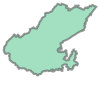

In [90]:
wgtn['geometry'][0]

In [91]:
# Create an OSMNX walking street netwoek for the Wellington bounding box
G = ox.graph_from_polygon(wgtn['geometry'][0], network_type='walk')

In [92]:
from shapely.geometry import Point, Polygon, LineString
from descartes import PolygonPatch

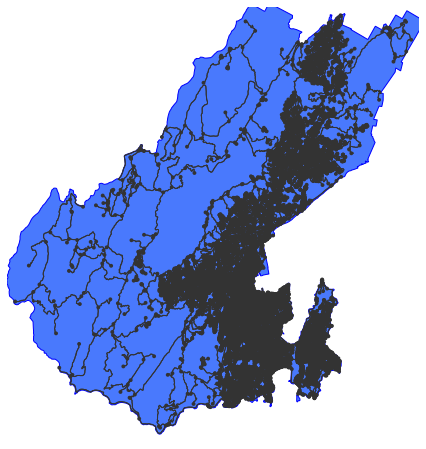

In [93]:
fig, ax = ox.plot_graph(G, bgcolor="#ffffff", node_color="#333333", edge_color="#333333", close=False, show=False)
# to this matplotlib axis, add the place shape as descartes polygon patches
patch = PolygonPatch(wgtn['geometry'][0], fc='#4979FD', ec='blue', zorder=-1)
ax.add_patch(patch)


# Walking to the park analysis 

## Basics of accessibility - routing

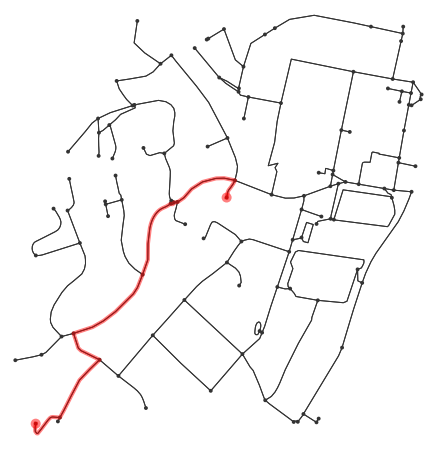

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [94]:
# Get nearest nodes for validation coordinates: 110 John Sim's Drive and Kipling St Play Area
playground_node = ox.get_nearest_node(G_sub, (wcc_playgrounds.iloc[32]['lat'], wcc_playgrounds.iloc[32]['lon']))
start_node = ox.get_nearest_node(G_sub, (-41.2292, 174.7922))

# Get the OSMIDs of the shortest path
route = route = ox.shortest_path(G, orig=playground_node, dest=start_node)
ox.plot_graph_route(G_sub, route, bgcolor = "#ffffff",  node_color="#333333", edge_color="#333333")

In [111]:
ox.plot_route_folium(G_sub, route)

## Routing for accessibility analysis - many to many

In [99]:
# export street network data
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)


# Setting indices of Edges gdfs to match expected dataframe for Pandana
gdf_edges = gdf_edges.reset_index()
gdf_edges['from_idx'] = gdf_edges['u']
gdf_edges['to_idx'] = gdf_edges['v']
gdf_edges= gdf_edges.set_index(['from_idx', 'to_idx'])
gdf_edges.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
gdf_nodes.index.name = 'id'

In [100]:
import pandana as pa

In [101]:
# Create a pandana network with data extracted from an OSMNX graph
flat_distance_network = pa.Network(gdf_nodes['x'], gdf_nodes['y'],
                                   gdf_edges['u'], gdf_edges['v'], 
                                   gdf_edges[['length']])

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 17239
Setting CH edge vector of size 43106
Range graph removed 44982 edges of 86212
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


## Calculate walking distance to nearest 10 parks

In [102]:
# do some basic pre-computation
flat_distance_network.precompute(2500 + 1)

# add wcc playgrounds to the network
flat_distance_network.set_pois(category='all',
                 x_col=wcc_playgrounds['lon'],
                 y_col=wcc_playgrounds['lat'],
                 maxdist=2500,
                 maxitems=10)

# calculate walking distance to nearest park
playground_accessibility_flat = flat_distance_network.nearest_pois(distance=2500, category='all', num_pois=10)

In [103]:
playground_accessibility_flat.head()

,1,2,3,4,5,6,7,8,9,10
id,,,,,,,,,,
34543603,308.924011,1008.682007,1302.954956,1322.417969,1739.904053,1820.655029,2500.000000,2500.000000,2500.000000,2500.000000
34543604,540.140991,1068.238037,1081.487061,1249.613037,1505.187012,1579.723999,2265.766113,2361.254883,2395.469971,2419.302979
34543605,798.169006,865.362000,1279.631958,1366.114014,1545.187012,1549.704956,1965.673950,2095.377930,2175.544922,2199.719971
34543610,661.002991,960.625000,1189.099976,1370.474976,1626.048950,1700.586060,2240.393066,2386.627930,2500.000000,2500.000000
34543611,924.080017,991.273010,1240.203003,1405.542969,1665.727051,1671.098022,2049.634033,2091.584961,2221.289062,2325.631104


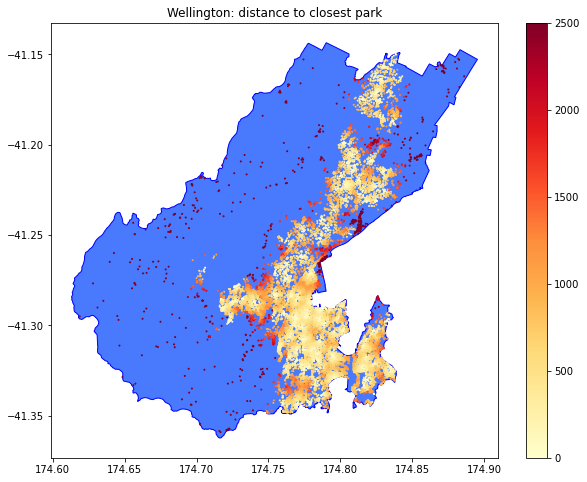

In [104]:
fig, ax = plt.subplots(figsize=(10,8))

plt.title('Wellington: distance to closest park')
plt.scatter(flat_distance_network.nodes_df.x,flat_distance_network.nodes_df.y, 
            c=playground_accessibility_flat[1], s=1, cmap='YlOrRd')
cb = plt.colorbar()
patch = PolygonPatch(wgtn['geometry'][0], fc='#4979FD', ec='blue', zorder=-1)
ax.add_patch(patch)
plt.show()

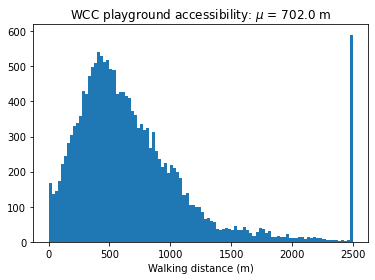

In [105]:
plt.hist(playground_accessibility_flat[1], bins=100);
plt.xlabel('Walking distance (m)');
plt.title("WCC playground accessibility: $\mu$ = {:.1f} m".format(np.mean(playground_accessibility_flat[1])));

## Park access isochrones

In [106]:
import networkx as nx

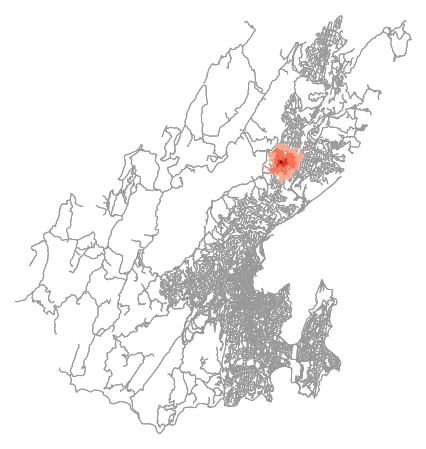

In [107]:
center_node = ox.get_nearest_node(G, (wcc_playgrounds.iloc[32]['lat'], wcc_playgrounds.iloc[32]['lon']))

trip_times = [50, 100, 500, 1000, 1500]

iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, bgcolor="#ffffff", node_alpha=0.8, node_zorder=2)

# Extra analyses


## Converting distance to travel time

A [simple search](https://books.google.co.nz/books?id=SyulBQAAQBAJ&pg=PA160&lpg=PA160&dq=walking+speed+gradient+accessibility&source=bl&ots=iKmtg73TIV&sig=ACfU3U3N5CAAtqoA0QzfSpJubylfjneWtA&hl=en&sa=X&ved=2ahUKEwiqqeKj3YTgAhVQXn0KHdSFDWsQ6AEwAHoECAkQAQ#v=onepage&q=walking%20speed%20gradient%20accessibility&f=false) led me to [Naismith's Rule](https://en.wikipedia.org/wiki/Naismith%27s_rule) and then to [Tobler's Hiking Function](https://en.wikipedia.org/wiki/Tobler%27s_hiking_function) to calculate travel time as a function of distance and gradient. 

I've chosen to go with Tobler's without too much rationale other than its simple form. Tobler's hiking function for speed, $\nu$, is a shifted exponential with three parameters: $a$, $b$ and $c$ which give the fastest speed, speed retardation due to gradient and shift from zero respectively. 

$$
\nu = a\exp^{\left(-b.|slope~+~c|\right)}
$$

Note that $slope$ here is the dimensionless quantity: $\frac{dh}{dx}$ (or, rise / run). Tobler's function can also be written with slope in degrees ($^{\circ}$). Speed in km/h can be converted to a travel time in minutes with the factor (60/1000). 

While I haven't read Tobler's original paper, a [brief exposition of other equivalent functional forms to Tobler's](https://rpubs.com/chrisbrunsdon/hiking) has been written up by Chris Brunsdon. For a more rigorous analysis, we'll need to refit the form above (or similar) as Brunsdon does for different types of pedestrians. According to NZTA and various other studies, there is significant heterogeneity in walking speed; noth from the route (terrain, incline etc) and also the characteristics of the walker e.g. carrying things, footwear, and demographics. We can likely imagine that a commuter will walk at a very different speed to a father taking his children to the playground during the daytime. Brunsdon's analysis itself shows a very different relationship to Tobler's. 

Function | a | b | c 
--- | --- | --- | ---
Tobler | 6 | 3.5 | 0.05 
Brunsdon | 3.557 | 2.03 | 0.133


In [108]:
# Function parameters
toblers = [6.0, 3.5, 0.05]
brunsdon = [3.557, 2.03, 0.13]

def hiking_time(grade, distance, params_list):
    W = params_list[0]*np.exp(- params_list[1]* np.abs(grade + params_list[2]))
    time_hr = (distance / 1000) / W
    time_mins = time_hr * 60.0
    return time_mins

def hiking_speed(grade, params_list):
    W = params_list[0]*np.exp(- params_list[1]* np.abs(grade + params_list[2]))
    return W

def flat_travel_time(distance, speed=5.0):
    time_hr = (distance / 1000) / speed
    time_mins = time_hr * 60.0
    return time_mins

In [109]:
street_grades = np.arange(-0.4, 0.4, 0.001)
travel_time_df = pd.DataFrame({'grade':street_grades})
travel_time_df['distance'] = 100

travel_time_df['toblers'] = hiking_time(travel_time_df['grade'], travel_time_df['distance'], params_list=toblers)
travel_time_df['brunsdon'] = hiking_time(travel_time_df['grade'], travel_time_df['distance'], params_list=brunsdon)
travel_time_df['flat_5khr'] = flat_travel_time(travel_time_df['distance'])
travel_time_df['flat_3khr'] = flat_travel_time(travel_time_df['distance'], 3.0)

travel_speed_df = pd.DataFrame({'grade':street_grades})
travel_speed_df['toblers'] = hiking_speed(travel_speed_df['grade'], params_list=toblers)
travel_speed_df['brunsdon'] = hiking_speed(travel_speed_df['grade'], params_list=brunsdon)

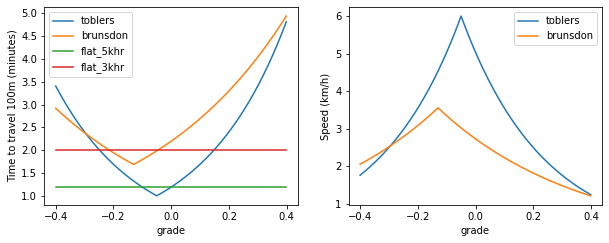

In [110]:
plt.figure(figsize=(10,8))
ax1 = plt.subplot(221)
travel_time_df[['toblers', 'brunsdon', 'flat_5khr', 'flat_3khr', 'grade']].plot(x='grade', ax = ax1)
plt.ylabel('Time to travel 100m (minutes)');

ax2 = plt.subplot(222)
travel_speed_df[['toblers', 'brunsdon','grade']].plot(x='grade', ax = ax2)
plt.ylabel('Speed (km/h)');

## Impact of hills
Distance is an excellent metric for driving or walking on flat land. For short travels by car or walking on flat land, distance can be directly converted to travel time. Most people have an intuitive understanding of their average driving speeds (50 km/h for residential roads in New Zealand) or their approximate walking speed on flat land (usually around 5 km / h for a fit adult as given in [Section 3.4 in NZTA pedestrian planning and design guide](https://www.nzta.govt.nz/assets/resources/pedestrian-planning-guide/docs/pedestrian-planning-guide.pdf)). Hills are not an issue for drivers provided road quality and safety are no different to flat land. But hills do impact travel time for pedestrians; which in turn impacts accessibility. 

> _How prohibitive is Wellington’s topography on pedestrian accessibility to playgrounds?_

Playgrounds are key amenities that can impact the quality of life for young families. Since they are also frequently accessed on foot, it's important to consider how accessible they really are. Particularly for suburbs with a high residential fraction.   
